In [46]:
import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [47]:
import pandas as pd 
# read text file into pandas DataFrame and 
# create header 
import os
Column_names = ["TIME_str", "TIME_sec", "latitude", "longitude", "ALTITUDE_FT", "GROUNDTRACK_DEG", \
            "GROUNDSPEED_KTS", "VERTICALSPEED_FT_PER_MIN", "Vertical_label",\
           "Horizontal_label", "Speed_label", "Turn_rate_deg_per_sec", "REL_HEADING", "DIST_TO_DEST", "intent", "sequence_of_modes" ]
Selected_col_names = ["sequence_of_modes"]
Target_category_name = "intent"
data_name = "Sequences_for_NN"
cwd = os.getcwd()
mypath = cwd + f"/../data/{data_name}/"
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['Traj_AAL1776-10551747_RH.dat',
 'Traj_AAL1339-11306671_RH.dat',
 'Traj_AAL1680-10699273_LH.dat']

In [48]:
count = 0
for file_name in onlyfiles:
    if "Traj" in file_name:
        if count == 0:
            file_path = mypath + file_name
            df = pd.read_csv(file_path, sep=",", header=None)
            df.columns = Column_names
            X_df = df[Selected_col_names]
            Y_target = df[Target_category_name]
        else:
            file_path = mypath + file_name
            df_temp = pd.read_csv(file_path, sep=",", header=None)
            df_temp.columns = Column_names
            
            X_df_temp = df_temp[Selected_col_names]
            Y_target_temp = df_temp[Target_category_name]
            X_df = pd.concat([X_df, X_df_temp],ignore_index=True)
            Y_target = pd.concat([Y_target, Y_target_temp])
        count +=1
        # if count >= 10:
        #     break

In [49]:
target_names =  list(set(list(Y_target)))
intent_map_to_num = list(set(list(Y_target)))
print("category:")
intent_map_to_num

category:


[' Aircraft is proceeding Nominally to Destination.',
 ' Aircraft is in a Right Holding Pattern',
 ' Aircraft is in a Left Holding Pattern',
 ' Not sure of aircraft intent.']

In [50]:
n_sample = len(X_df)
print("number of points:", n_sample)
X_df = X_df.head(n_sample)
Y_target = Y_target.head(n_sample)
Y = []
for y in Y_target:
    for idx, s in enumerate(intent_map_to_num):
        if s == y:
            Y.append(idx)
Y = np.array(Y)
X_df["sequence_of_modes"][0]

number of points: 13993


' Maintain Current Heading:'

In [51]:
Y_target

0        Aircraft is proceeding Nominally to Destination.
1        Aircraft is proceeding Nominally to Destination.
2        Aircraft is proceeding Nominally to Destination.
3        Aircraft is proceeding Nominally to Destination.
4        Aircraft is proceeding Nominally to Destination.
                              ...                        
7731                         Not sure of aircraft intent.
7732                         Not sure of aircraft intent.
7733                         Not sure of aircraft intent.
7734                         Not sure of aircraft intent.
7735                         Not sure of aircraft intent.
Name: intent, Length: 13993, dtype: object

In [52]:
# identify type of mode
mode_collection = []
for i in range(n_sample):
    mode_collection.extend(X_df["sequence_of_modes"][i].split(":")[:-1])
mode_collection = mode_collection + ["Null"]
mode_collection = list(set(mode_collection))
print(f"{len(mode_collection)} modes:")
for idx, m in enumerate(mode_collection):
    print(idx, m)

8 modes:
0 Null
1 No Conclusion-Horizontal
2 Maintain Current Heading
3  Maintain Current Heading
4 Fly Towards Destination
5 Flying opposite established course
6 Hold Right Turn 
7 Hold Left Turn 


[1, 7, 1, 6, 1]
(8, 5)


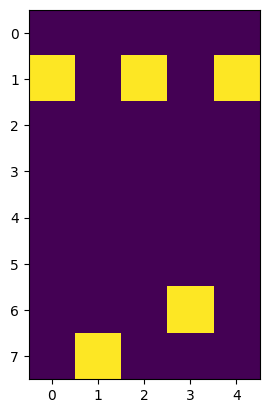

In [53]:
# functions for transferring modes to images
length_of_sequence = 5
def transfer_modes_to_values(modes):
    rtn = []
    for cur_m in modes:
        for idx, m in enumerate(mode_collection):
            if cur_m == m:
                rtn.append(idx)
    return rtn
x = transfer_modes_to_values(X_df["sequence_of_modes"][13992].split(":")[-(length_of_sequence+1):-1])
print(x)
def transfer_nums_to_one_hots(values):
    return np.eye(len(mode_collection))[values].transpose()
x = transfer_nums_to_one_hots(x)
print(x.shape)
plt.imshow(x)

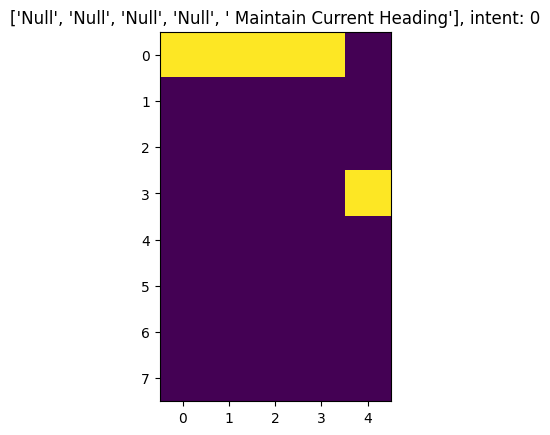

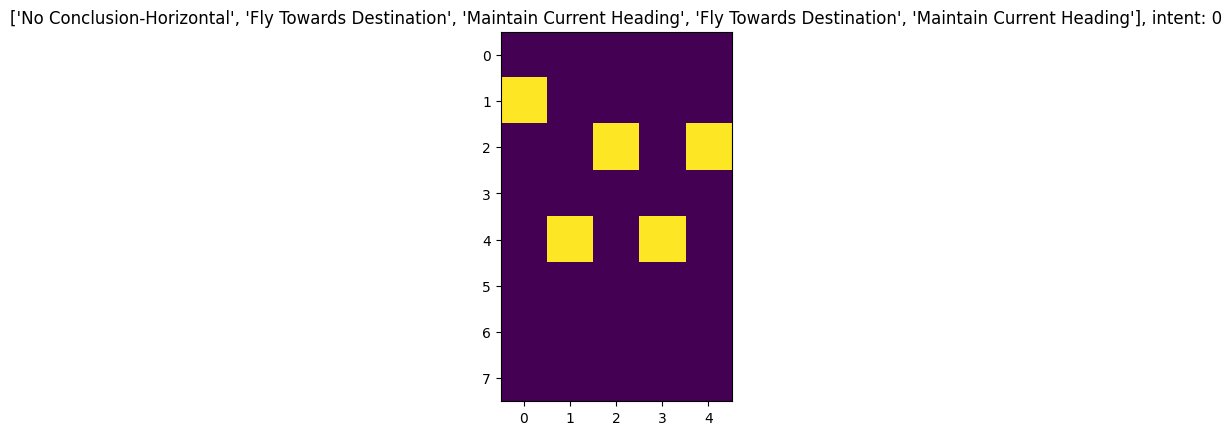

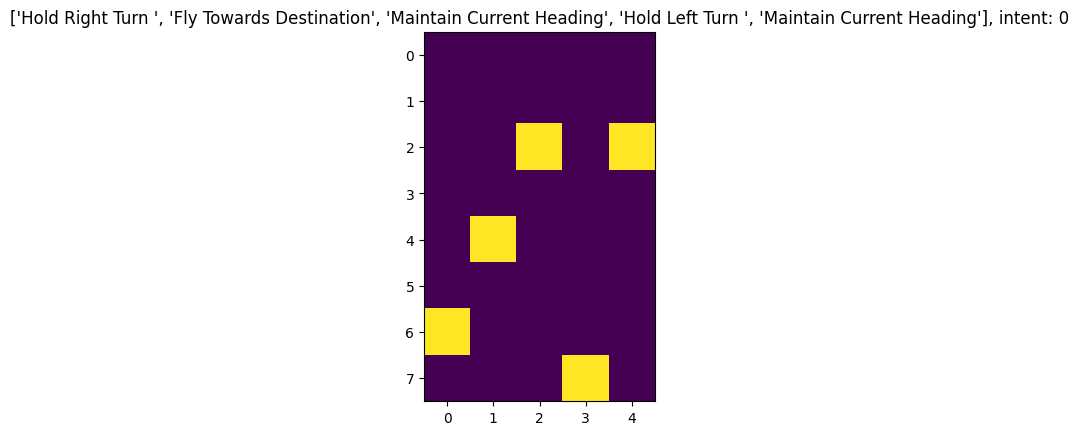

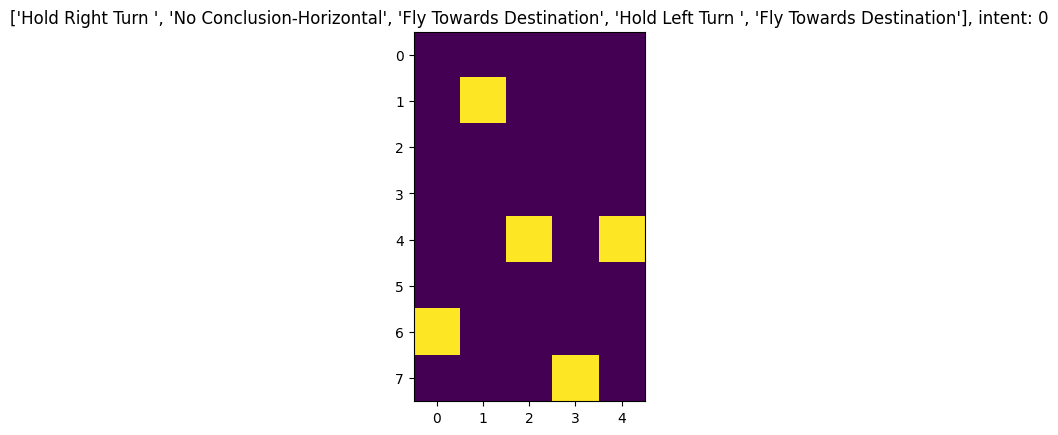

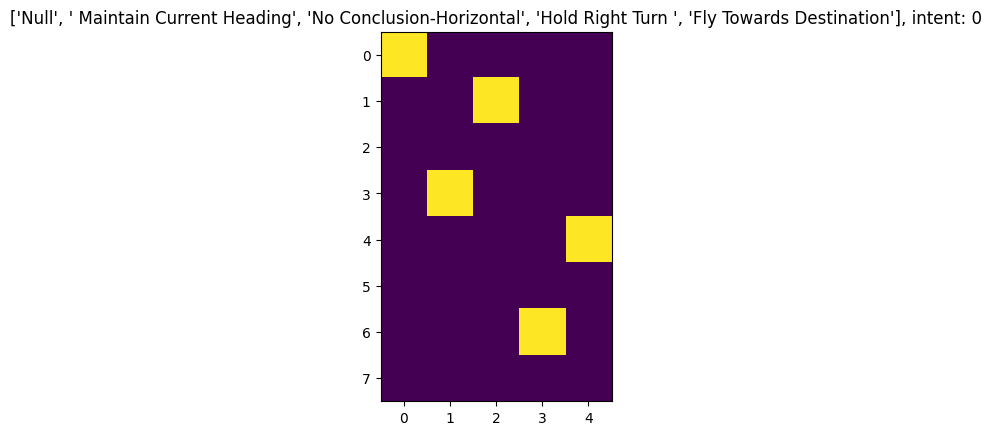

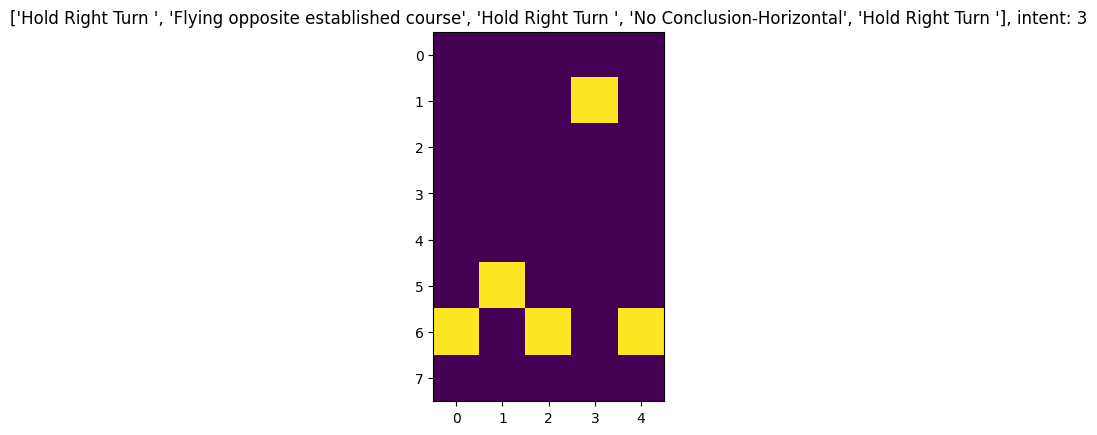

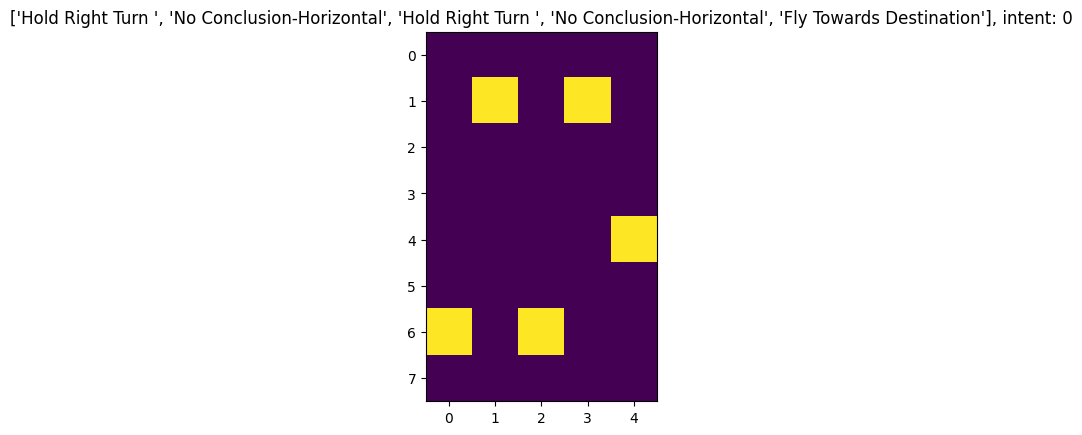

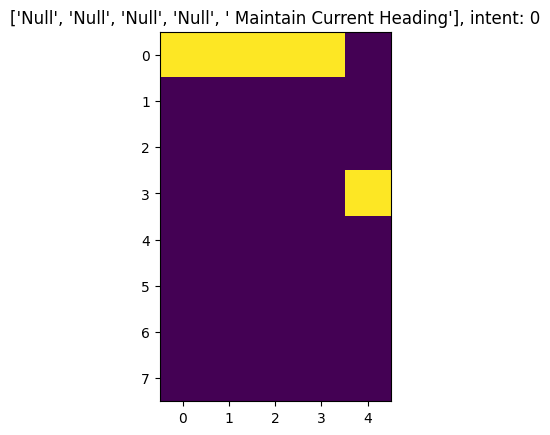

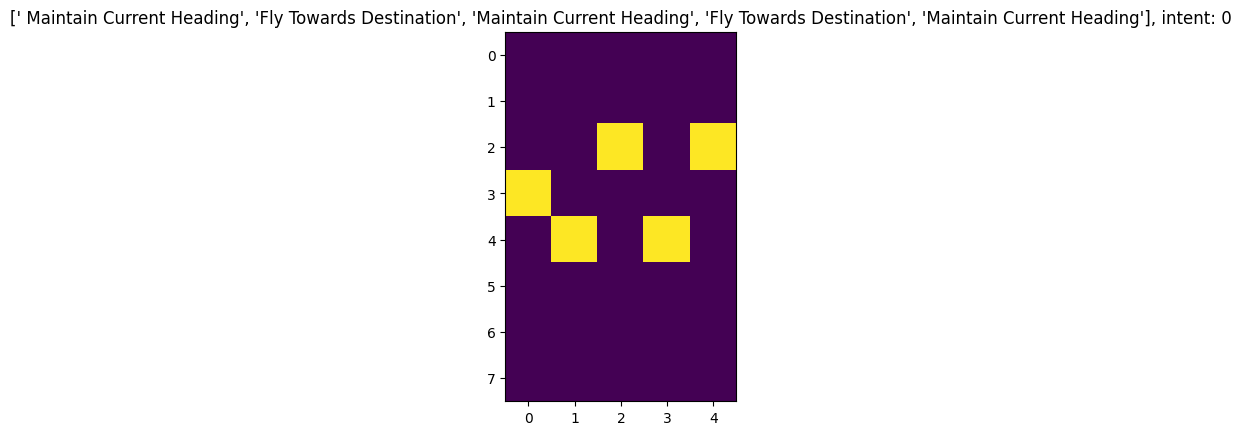

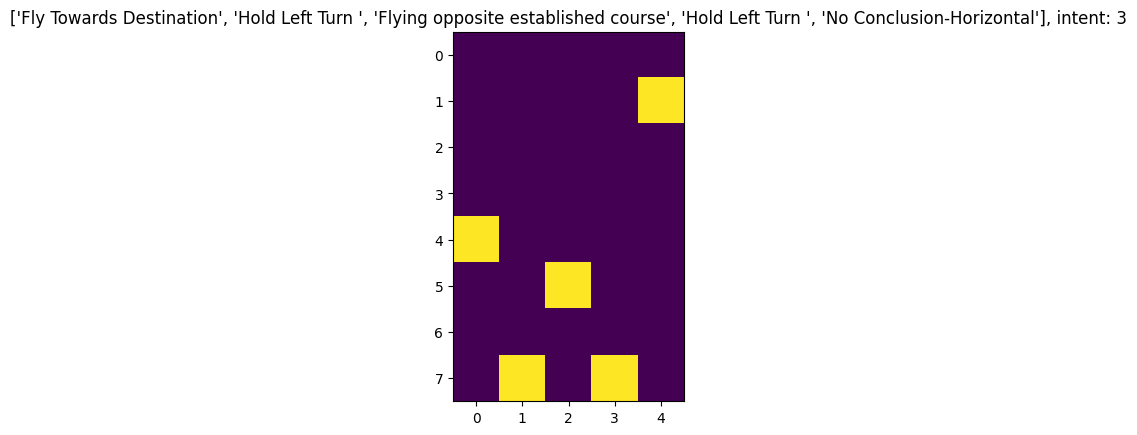

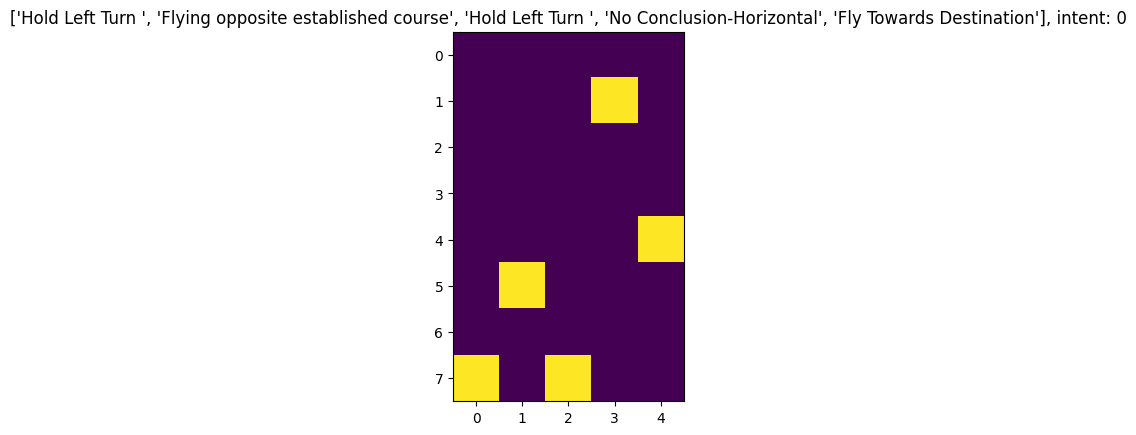

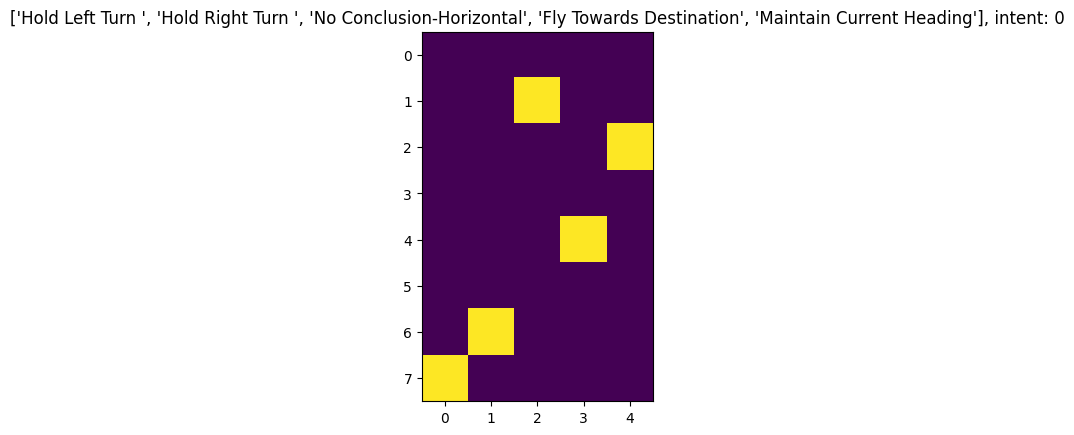

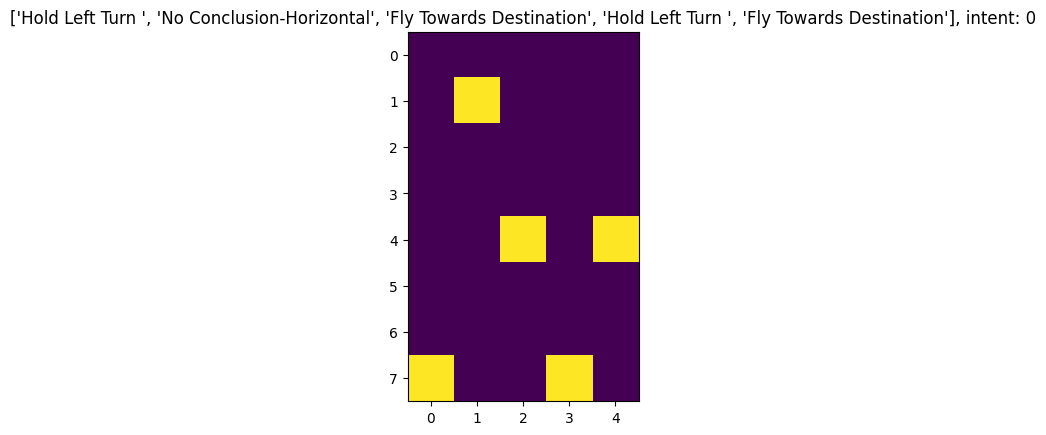

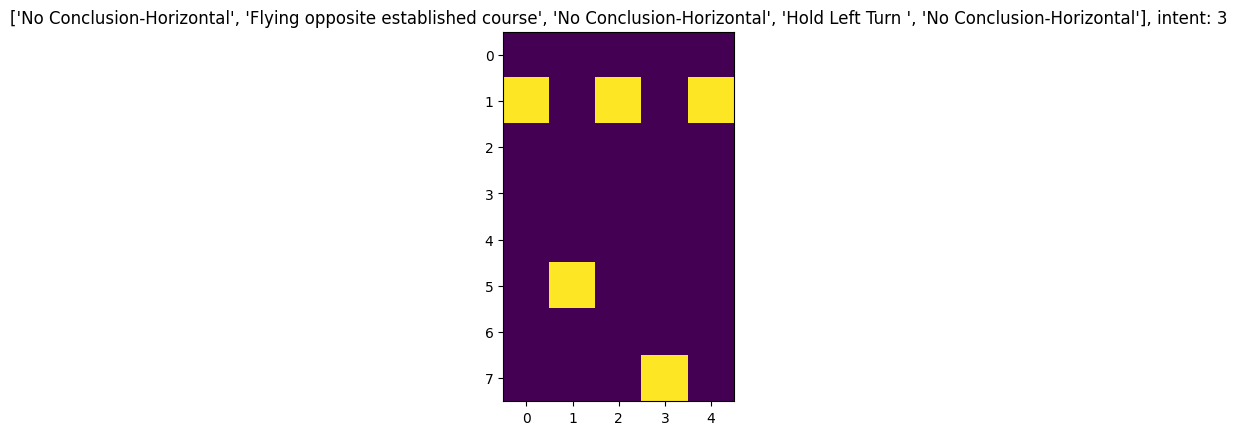

In [56]:
# generate images dataset
X = []
for i in range(n_sample):
    cur_sequence = X_df["sequence_of_modes"][i].split(":")
    if len(cur_sequence) < length_of_sequence + 1:
        cur_sequence = ["Null"] * (length_of_sequence + 1 - len(cur_sequence)) + cur_sequence
    x = transfer_modes_to_values(cur_sequence[-(length_of_sequence+1):-1])
    x = transfer_nums_to_one_hots(x)
    if i % 1000 == 0:
        fig, ax = plt.subplots()
        plt.title(str(cur_sequence[-(length_of_sequence+1):-1])+f", intent: {Y[i]}")
        plt.imshow(x)
        plt.show()
    X.append(x.reshape(-1))
X = np.array(X)
Y = np.array(Y)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((9375, 40), (4618, 40), (9375,), (4618,))

In [58]:
import torch
X_test = X_test.astype(np.float32)
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(np.asarray(Y_test))

In [59]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self):
        self.X=torch.from_numpy(X_train)
        self.Y=torch.from_numpy(Y_train)
        self.len=self.X.shape[0]
    def __getitem__(self,index):      
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len
data=Data()
loader=DataLoader(dataset=data,batch_size=64)

In [60]:
input_dim= 40     # how many Variables are in the dataset
output_dim= 4    # number of classes
import torch.nn as nn
class Net(nn.Module):
    def __init__(self,in_dim,out_dim):
        super(Net,self).__init__()
        self.l1=nn.Linear(in_dim,512)
        self.l4=nn.Linear(512,out_dim)

    def forward(self,x):
        x=torch.relu(self.l1(x))
        return self.l4(x)

In [61]:
import torch.optim as optim
device="cuda" if torch.cuda.is_available else "cpu" 

model=Net(input_dim, output_dim)
criterion=nn.CrossEntropyLoss() 
optimizer=optim.SGD(model.parameters(),lr=0.01) 

In [62]:

X_train = X_train.astype(np.float32)
x = torch.from_numpy(X_train)
y = torch.from_numpy(Y_train)

In [63]:
import torch
from torch.utils.data import Dataset,DataLoader

class MyDataset():
    def __init__(self,data,label=None):
        if label is not None: #train set/val set
            self.data=data
            self.label=label
        else: #test set
            self.data=data


    def __getitem__(self,index):
        if self.label is not None: #for train set/val set
            return self.data[index],self.label[index]
        else: #for test set(no label)
            return self.data[index]

    def __len__(self):
        return len(self.data)

In [64]:
train_dataloader = DataLoader(MyDataset(X_train,Y_train), batch_size=64)


In [65]:
def train(n_epochs,dataloader,model,criterion,optimizer):
    train_loss=0
    min_val_loss=1000  
    num_batches=len(dataloader)

    model.train() 
    for i in range(n_epochs):
        for batch_idx, (inputs,labels) in enumerate(dataloader):
            inputs,labels=inputs,labels#GPU
            outputs=model(inputs)
            loss=criterion(outputs,labels)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx%1000==0:
                #print(f"current batch:{batch_idx}/all:{num_batches},loss:{loss.item():.6f}")
                loss_list.append(loss.item())
                if loss.item()<=0.01:
                    return 
    test(model, device, Y_test)
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [66]:
epochs = 1000
loss_list = []
train(epochs, train_dataloader, model, criterion, optimizer)
print("Done!")

Done!


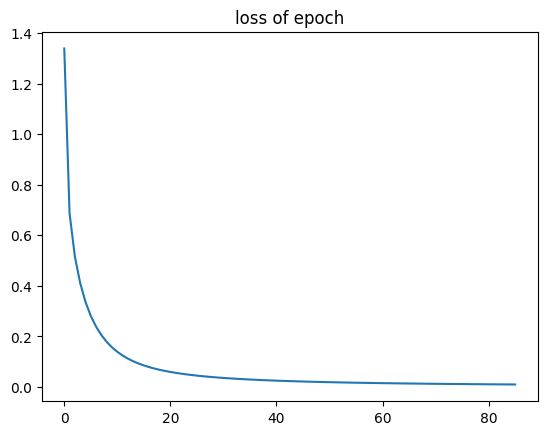

In [67]:
fig, ax = plt.subplots()
plt.plot(range(len(loss_list)),np.array(loss_list))
plt.title("loss of epoch")
plt.show()

In [68]:
correct = 0
pred=model(X_test)
pred = pred.argmax(dim=1, keepdim=True)
for i in range(len(Y_test)):
    if pred[i][0] == Y_test[i]:
        correct+= 1
print(correct/len(Y_test))

0.9995669120831528
